# Tilt and Compliance Removal for OBS Data: Continuous with Correction for Orientations
### Xiaotao Yang @ Harvard University
This notebook contains examples of compliance corrections using data downloaded from IRIS. The functions for tilt and compliance corrections are in module seispy.obsmaster.
### References:
Bell, S. W., D. W. Forsyth, & Y. Ruan (2015), Removing Noise from the Vertical Component Records of Ocean-Bottom Seismometers: Results from Year One of the Cascadia Initiative, Bull. Seismol. Soc. Am., 105(1), 300-313, doi:10.1785/0120140054.

Tian, Y., & M. H. Ritzwoller (2017), Improving ambient noise cross-correlations in the noisy ocean bottom environment of the Juan de Fuca plate, Geophys. J. Int., 210(3), 1787-1805, doi:10.1093/gji/ggx281.

Helen A Janiszewski, James B Gaherty, Geoffrey A Abers, Haiying Gao, Zachary C Eilon, Amphibious surface-wave phase-velocity measurements of the Cascadia subduction zone, Geophysical Journal International, Volume 217, Issue 3, June 2019, Pages 1929–1948, https://doi.org/10.1093/gji/ggz051

## Step 0. Load needed packages.
Some functions are imported from the utils.py and the obsmaster.py.

In [1]:
#import needed packages.
from seisgo import utils
from seisgo import obsmaster as obs
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.core import Stream,Trace
from IPython.display import clear_output
from obspy.clients.fdsn import Client

## Step 1. Set global parameters for downloading
Set downloading and saving parameters. We download the same data as Figure 5 in Janiszewski et al. (2019).The following figure is from their paper for reference.
Earthquake information:
M 7.1 - Vanuatu
2012-02-02 13:34:40 (UTC)17.827°S 167.133°E 23.0 km depth

![title](embededfigs/JaniszewskiGJI2019Fig5.png)

In [2]:
# get data from IRIS web service

net="7D"
stalist=["FN07A","G30A"]#["G03A","J35A","J44A","J65A"]
starttime = obspy.UTCDateTime("2012_02_02_0_0_0")       
endtime   = obspy.UTCDateTime("2012_02_02_14_0_0")
stlamin,stlamax,stlomin,stlomax= 37.0,52.0,-133.0,-116.0

"""
parameters for processing
"""
rmresp=True #remove instrument response
# parameters for butterworth filter
samp_freq=10
pfreqmin=0.002
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.95*pfreqmin;f2=pfreqmin
if 1.05*pfreqmax > 0.48*samp_freq:
    f3 = 0.45*samp_freq
    f4 = 0.48*samp_freq
else:
    f3 = pfreqmax
    f4= 1.05*pfreqmax
pre_filt  = [f1,f2,f3,f4]

"""
parameters for TC removal
"""
window=3600
overlap=0.2
taper=0.08
qc_freq=[0.004, 1]
plot_correction=True
normalizecorrectionplot=True
tc_subset=['ZP-H']

"""
parameters for orientation correlaiton for horizontal components
"""
#read in station list.
obs_orient_file='OBS_orientation_Cascadia.csv'
orient_data=obs.get_orientations(obs_orient_file)

## Step 2. Download data and do TC noise removal through a wrapper

station 7D.FN07A --> pressure channel: HDH
station 7D.FN07A --> seismic channels: HH1, HH2, HHZ
  downsamping from 125 to 10
  removing response using inv for 7D.FN07A.HH1
  removing response using inv for 7D.FN07A.HH2
  removing response using inv for 7D.FN07A.HHZ
  removing response using inv for 7D.FN07A.HDH
all cpu times:
23.77958917617798 4.507815837860107
station 7D.FN07A, filtered at [ 0.005,  0.100]
station 7D.FN07A, filtered at [ 0.005,  0.100]


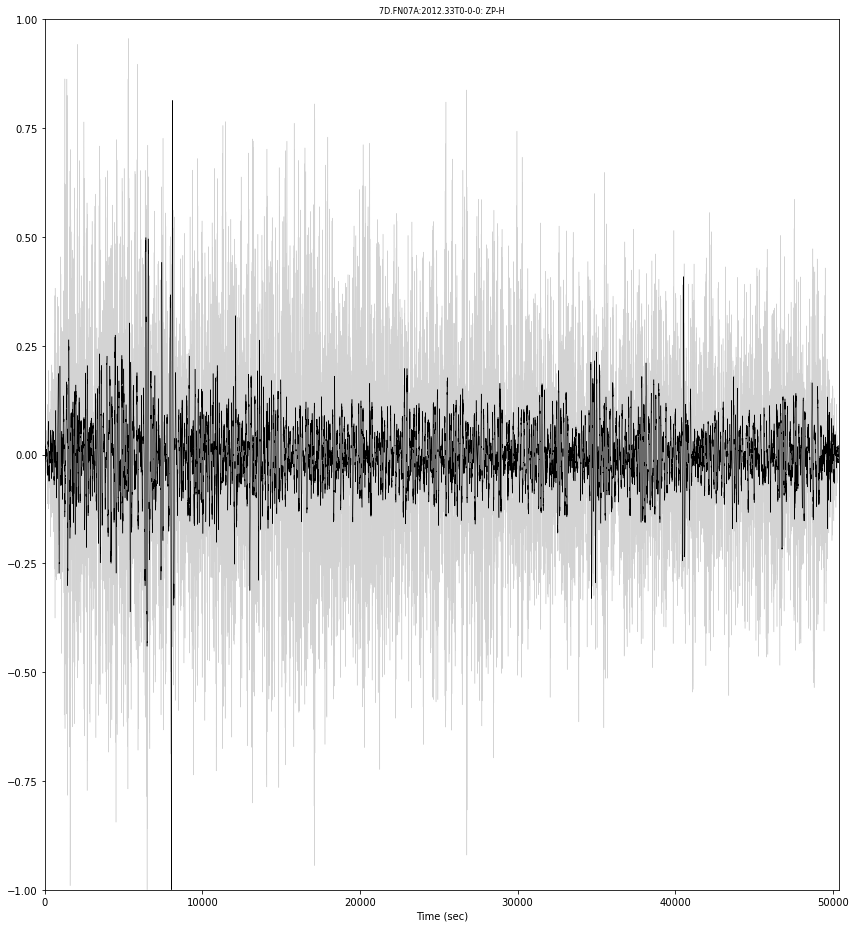

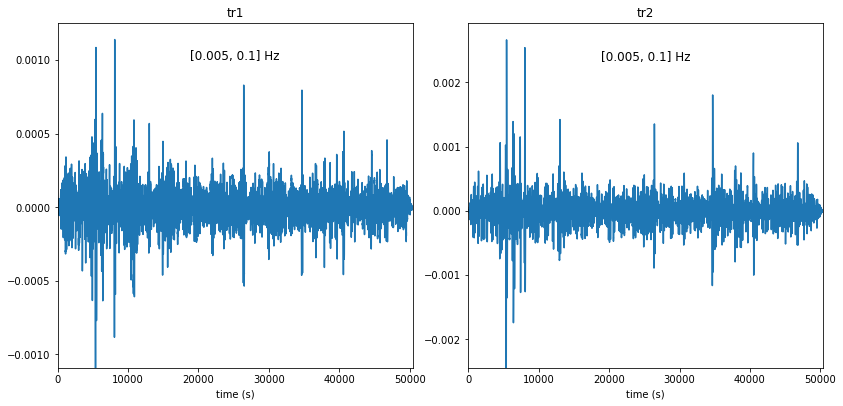

station 7D.FN07A, filtered at [ 0.005,  0.100]
station 7D.FN07A, filtered at [ 0.005,  0.100]


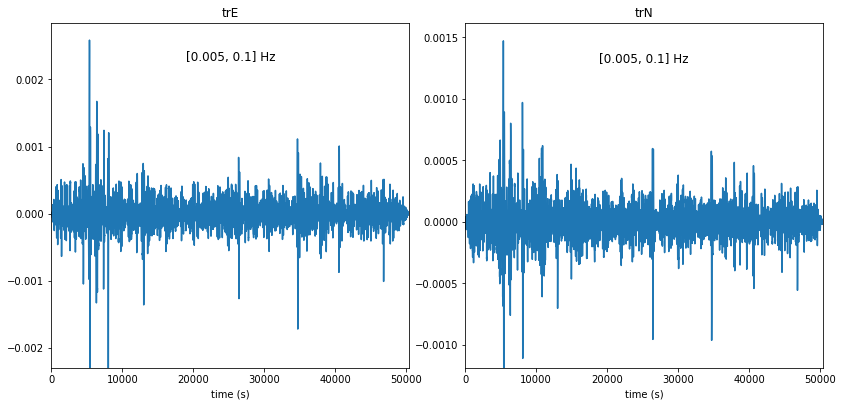

  saving all component after TC removal to: 7D.FN07A_2012.33T0-0-0_LEN50399.9s_corrected.h5
station 7D.G30A --> pressure channel: BDH
station 7D.G30A --> seismic channels: BH1, BH2, BHZ
  downsamping from 50 to 10
  removing response using inv for 7D.G30A.BH1
  removing response using inv for 7D.G30A.BH2
  removing response using inv for 7D.G30A.BHZ
  removing response using inv for 7D.G30A.BDH
all cpu times:
33.43300819396973 4.5076539516448975
station 7D.G30A, filtered at [ 0.005,  0.100]
station 7D.G30A, filtered at [ 0.005,  0.100]


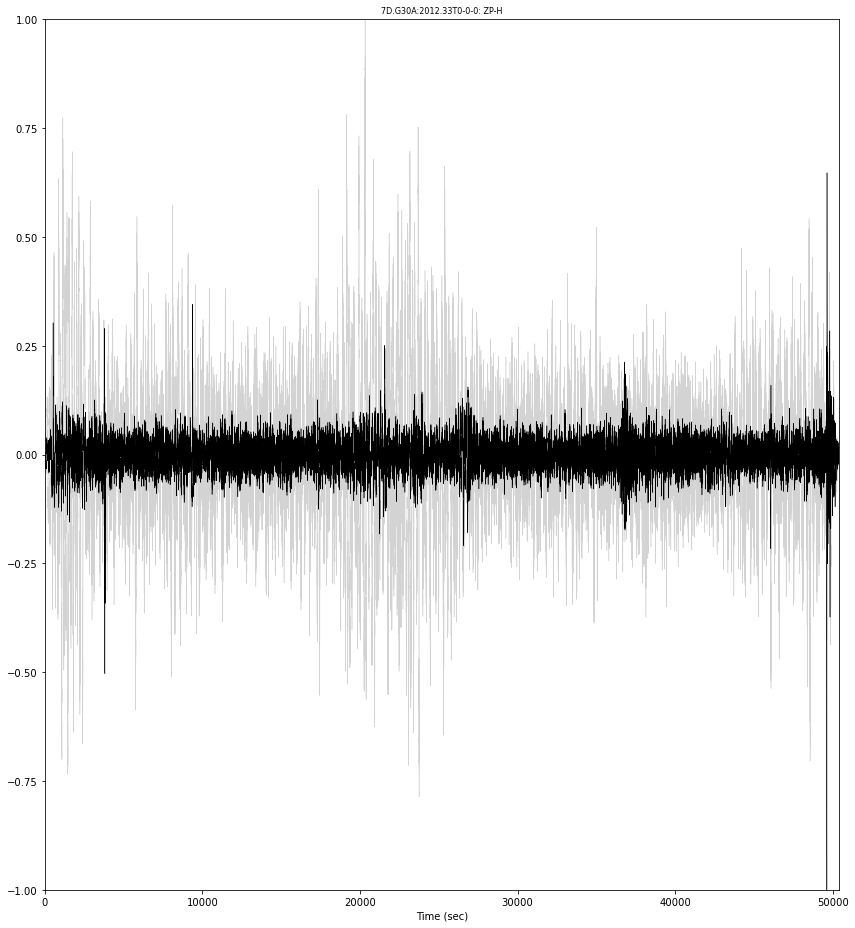

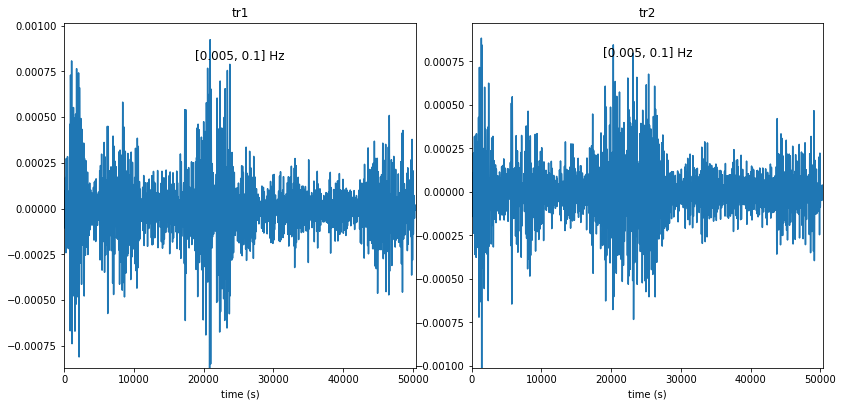

station 7D.G30A, filtered at [ 0.005,  0.100]
station 7D.G30A, filtered at [ 0.005,  0.100]


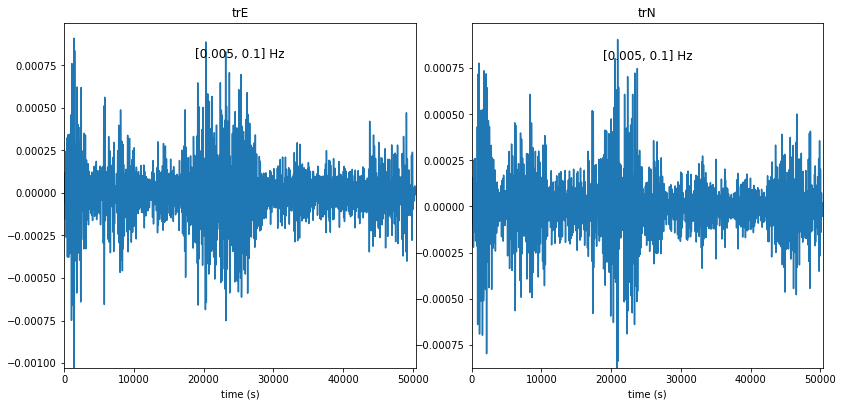

  saving all component after TC removal to: 7D.G30A_2012.33T0-0-0_LEN50399.9s_corrected.h5


In [3]:
"""
Loop through stations
"""
savetofile=True
if savetofile:
    client=Client('IRIS')
    !rm *.h5
    
correctdictall=dict()
normalizecorrectionplot=True
for ista in stalist:
    t0=time.time()
    """
    a. Downloading data that will be used to compute the transfer functions.
    """
    tr1,tr2,trZ,trP,sta_inv = obs.getobsdata(net,ista,starttime,endtime,samp_freq=samp_freq,
                                  plot=False,rmresp=rmresp,pre_filt=pre_filt,getstainv=True)
    ta=time.time() - t0
    """
    b. Call the wrapper to remove the tilt and compliance noise.
    """
    spectra,transfunc,correct=obs.TCremoval_wrapper(
            tr1,tr2,trZ,trP,window=window,overlap=overlap,merge_taper=taper,
            qc_freq=qc_freq,qc_spectra=True,fig_spectra=False,
            save_spectrafig=False,fig_transfunc=False,correctlist=tc_subset)
    trZtc,tgtemp=obs.correctdict2stream(trZ,correct,tc_subset)

    if plot_correction:
        obs.plotcorrection(trZ,correct,normalize=normalizecorrectionplot,freq=[0.005,0.1],
                       size=(12,6),save=True,form='png')
        
    tb=time.time() - t0 - ta
    
    print('all cpu times:')
    print(ta,tb)
    
    """
    c. Correction horizontal orientations
    """
    trE,trN = obs.correct_orientations(tr1,tr2,orient_data)
    utils.plot_trace([tr1,tr2],size=(12,6),title=['tr1','tr2'],freq=[0.005,0.1],
                   subplotpar=(1,2))
    utils.plot_trace([trE,trN],size=(12,6),title=['trE','trN'],freq=[0.005,0.1],
                   subplotpar=(1,2))

    """
    d. Save to ASDF file.
    """
    if savetofile:
        year = trZ.stats.starttime.year
        julday = trZ.stats.starttime.julday
        hour = trZ.stats.starttime.hour
        mnt = trZ.stats.starttime.minute
        sec = trZ.stats.starttime.second
        tstamp = str(year) + '.' + str(julday)+'T'+str(hour)+'-'+str(mnt)+'-'+str(sec)
        fnamebase = trZ.stats.network+'.'+trZ.stats.station+'_'+tstamp+'_LEN'+\
                    str(trZ.stats.endtime-trZ.stats.starttime)+'s'

        fname=fnamebase+'_corrected.h5'
        tags=[]
        for tr in [trE,trN,trZtc[0],trP]:
            if len(tr.stats.location) == 0:
                tlocation='00'
            else:
                tlocation=tr.stats.location

            tags.append(tr.stats.channel.lower()+'_'+tlocation.lower())

        print('  saving all component after TC removal to: '+fname)
        utils.save2asdf(fname,Stream(traces=[trE,trN,trZtc[0],trP]),tags,sta_inv=sta_inv)